<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/05_Transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ of pre-trained model.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)

## What we're going to cover

We're going to go through the follow with TensorFlow:
- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data.
- Using the Keras Functional API (a different way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data:
  - Model 0: a transfer learning model using Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2 : a feature extraction transfer learning model on 10 % of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

In [1]:
# Using a GPU?
!nvidia-smi

Mon Oct 10 17:38:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Throughout your machine learning experiments, you'll likely come accross snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again. But as you might have guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper functions script such as `helper_functions.py`. And then import the necessary functionality when you need it.


Let's see what this looks like.

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py 

--2022-10-10 17:38:50--  https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2631 (2.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.57K  --.-KB/s    in 0s      

2022-10-10 17:38:51 (51.8 MB/s) - ‘helper_functions.py’ saved [2631/2631]



In [3]:
# import Helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## 1O Food Classes: Working with less data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, `image_dataset_from_directory()` which is part of the `tf.keras.preprocessing` module.

Finally, we'll also be practicing using the [`Keras Functional API`](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-10-10 17:38:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   232MB/s    in 0.7s    

2022-10-10 17:38:54 (232 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# unzip the data
unzip_data("/content/10_food_classes_10_percent.zip")

In [6]:
# walkthrough the directories
walk_through_dir("/content/10_food_classes_10_percent")

/content/10_food_classes_10_percent: There are 2 directories and 0 files
/content/10_food_classes_10_percent/train: There are 10 directories and 0 files
/content/10_food_classes_10_percent/train/pizza: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/ice_cream: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/chicken_wings: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/chicken_curry: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/sushi: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/hamburger: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/fried_rice: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/ramen: There are 0 directories and 75 files
/content/10_food_classes_10_percent/train/grilled_salmon: There are 0 directories and 75 files
/content/10_food_classes_10_percent

In [7]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously we've used the `ImageDataGenerator` class. And while this works well and is still very commonly used, this time we're going to use the `image_data_from_directory` function.

It works much the same way as `ImageDataGenerator`'s `flow_from_directory` method meaning your images need to be in the following file format:

Example of file structure:
10_food_classes_10_percent <- top level folder
└───train <- training images 
│   │   │     
│   └───pizza
    
│- - - - -  1008104.jpg'

│- - - - -  1638227.jpg
 
│- - - - -  ...      
│   └───steak

│- - - - -  1000205.jpg

│- - - - -  1647351.jpg

│- - - - -   ...
      
└───test <- testing images

│   └───pizza

│- - - - -  1001116.jpg

│- - - - -  1507019.jpg

│- - - - -  ...      

│   └───steak

│- - - - -  100274.jpg

│- - - - -  1653815.jpg

│- - - - -  ...   

One of the main benefits of using `tf.keras.preprocessing.image_dataset_from_directory()` rather than `ImageDataGenerator` is that it creates a `tf.data.Dataset` object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.



In [8]:
# Create data inputs

import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE) # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)                                                                         

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


It looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` function are:
- `directory` - the filepath of the target directory we're loading images in from.
- `image_size` - the target size of the images we're going to load in (height, width).
- `batch_size` - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

In [9]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:
- `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channel (red, green blue).
- `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
- Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using `tf.data.Dataset` API are the associated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [10]:
# get the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
train_data_10_percent.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images)
  print(labels)

tf.Tensor(
[[[[1.06357140e+02 5.43571434e+01 5.83571434e+01]
   [1.05071426e+02 5.30714264e+01 5.70714264e+01]
   [1.03285713e+02 5.32857132e+01 5.58571396e+01]
   ...
   [1.65846893e+02 1.83418365e+02 1.83418365e+02]
   [1.66642868e+02 1.84642868e+02 1.84642868e+02]
   [1.67897980e+02 1.87897980e+02 1.86897980e+02]]

  [[1.08882652e+02 5.38826523e+01 5.88826523e+01]
   [1.05209183e+02 5.29948997e+01 5.70663261e+01]
   [1.01071426e+02 5.09591827e+01 5.40153046e+01]
   ...
   [1.64974487e+02 1.82545959e+02 1.82331696e+02]
   [1.68214294e+02 1.86214294e+02 1.86214294e+02]
   [1.66734650e+02 1.86734650e+02 1.87734650e+02]]

  [[1.02576530e+02 5.53520393e+01 5.80000000e+01]
   [9.98979568e+01 5.52142868e+01 5.81836739e+01]
   [9.69030609e+01 5.43826523e+01 5.90000000e+01]
   ...
   [1.67020447e+02 1.84591919e+02 1.84377655e+02]
   [1.64729584e+02 1.82729584e+02 1.83158157e+02]
   [1.68352173e+02 1.88352173e+02 1.89352173e+02]]

  ...

  [[1.61637756e+02 9.22805557e+01 6.06629086e+00]
   [1

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`)

## Model 0: Building a transfer learning model using the Keras Functional API

Let's build a model.

To do so we're going to be using the `tf.keras.applications` module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetB0` from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.
> **Note :** As of writing, the `EfficientNetB0` models in `tf.keras.applications` module do not require images to be normalized on input, where as many of the other models do. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using `tf.keras.layers.GlobalAveragePooling2D()` or `tf.keras.layers.GlobalMaxPooling2D()` though the former is more common in practice).
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using `tf.keras.Model()`
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks.

In [13]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='inputLayer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="outputLayer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [14]:
# Compile our model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [15]:
# fit our model
history_model0 = model_0.fit(train_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             validation_steps=int(0.25*len(test_data_10_percent)), # validate on only 25% of test_data (validate quicker)
                             callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

Saving TensorBoard log files to :transfer_learning/10_percent_feature_extract/2022-10-10_17:39:03
Epoch 1/5
24/24 [==============================] - 19s 224ms/step - loss: 1.8486 - accuracy: 0.4360 - val_loss: 1.2794 - val_accuracy: 0.7401
Epoch 2/5
24/24 [==============================] - 5s 185ms/step - loss: 1.1241 - accuracy: 0.7480 - val_loss: 0.8874 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 5s 185ms/step - loss: 0.8274 - accuracy: 0.8133 - val_loss: 0.6982 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 4s 153ms/step - loss: 0.6826 - accuracy: 0.8413 - val_loss: 0.6426 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.5937 - accuracy: 0.8547 - val_loss: 0.5806 - val_accuracy: 0.8388


In [16]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 77ms/step - loss: 0.6086 - accuracy: 0.8388


[0.6086381673812866, 0.8388000130653381]

After a minute or so of training our model performs incredibly well on the training and test sets. 

It's important to note the kind of transfer learning we used here is called **feature extraction** transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetB0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

In [17]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [18]:
# summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [19]:
# summary of the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has five layers but really, one of those layers (`EfficientNetB0`) has 236 layers.

You can see how the output shape started out as `(None,224,224,3)` for the input layer but was transformed to be `(None, 10)` by the output layer, where None is the placeholder for the batch size.

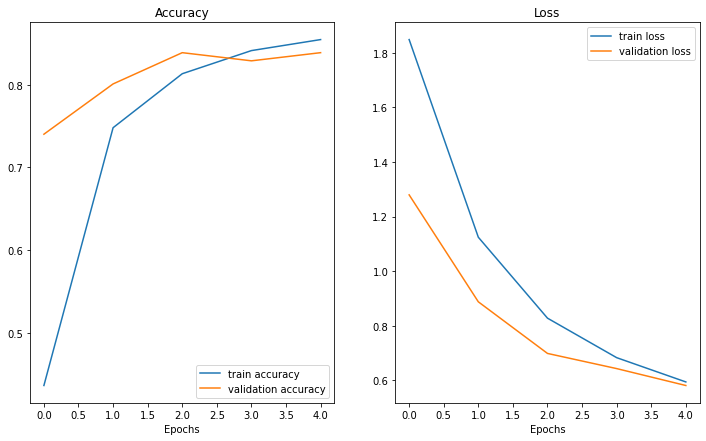

In [20]:
# Check out our model's training curves
plot_loss_curves(history_model0)

## Getting a feature vector from a trained model

The `tf.keras.layers.GlobalAveragePooling2D()` layer transforms a 4D tensor into a 2D tensor by averaging the value across the inner-axes.

Let's see an example.

In [21]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Random input_tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of the global average pooled random tensor: {global_average_pooled_tensor.shape}")
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")


Shape of the random tensor: (1, 4, 4, 3)
Random input_tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of the global average pooled random tensor: (1, 3)
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]


We can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed  the input tensor from shape `(1,4,4,3)` to `(1,3)`. It did so by averaging the `input_tensor` accross the middle axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifyind the appropriate axes.

In [22]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [23]:
# Example with GlobalMaxPool2D
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Global max pooled tensor:\n {global_max_pooled_tensor}\n")

# Replicate the GlobalMaxPool2D layer with tf.reduce_max
reduce_max_tensor = tf.reduce_max(input_tensor, axis=[1,2])
print(f"Reduce max pooled tensor:\n {reduce_max_tensor}")

Global max pooled tensor:
 [[0.9058464 1.1603122 1.6994323]]

Reduce max pooled tensor:
 [[0.9058464 1.1603122 1.6994323]]


Doing this not only makes the ouput of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense())`, it also condenses the information found by the base model into a lower dimension **feature vector**.

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data ?

What kind of results do you think we can get using 100x less data than the original CNN models we build ourselves?

Why don't we answer that question while running the following modelling experiments:

1. `model_1`: USe feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the `tf.keras.layers.experimental.preprocessing` module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

### Download and preprocessed data for model 1

In [24]:
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-10-10 17:39:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  68.9MB/s    in 1.8s    

2022-10-10 17:40:00 (68.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# unzip data
unzip_data("10_food_classes_1_percent.zip")

In [26]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [27]:
# walkthroug the data
walk_through_dir("10_food_classes_1_percent")

10_food_classes_1_percent: There are 2 directories and 0 files
10_food_classes_1_percent/train: There are 10 directories and 0 files
10_food_classes_1_percent/train/pizza: There are 0 directories and 7 files
10_food_classes_1_percent/train/ice_cream: There are 0 directories and 7 files
10_food_classes_1_percent/train/chicken_wings: There are 0 directories and 7 files
10_food_classes_1_percent/train/chicken_curry: There are 0 directories and 7 files
10_food_classes_1_percent/train/sushi: There are 0 directories and 7 files
10_food_classes_1_percent/train/hamburger: There are 0 directories and 7 files
10_food_classes_1_percent/train/fried_rice: There are 0 directories and 7 files
10_food_classes_1_percent/train/ramen: There are 0 directories and 7 files
10_food_classes_1_percent/train/grilled_salmon: There are 0 directories and 7 files
10_food_classes_1_percent/train/steak: There are 0 directories and 7 files
10_food_classes_1_percent/test: There are 10 directories and 0 files
10_food_cl

Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the `image_dataset_from_directory()` method.

In [28]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How ?

Using the `tf.keras.layers.experimental.preprocessing` module and creating a dedicated data augmentation layer.

This is a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

- Preprocessing of the images (augmenting them) happens on the GPU rather on the CPU (much faster).
  - Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
- Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)

>🤔 Note: At the time of writing, the preprocessing layers we're using for data augmentation are in experimental status within the in TensorFlow library. This means although the layers should be considered stable, the code may change slightly in a future version of TensorFlow. For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

The data augmentation transformations we're going to use are:
- **RandomFlip** - flips image on horizontal or vertical axis.
- **RandomRotation** - randomly rotates image by a specified amount.
- **RandomZoom** - randomly zooms into an image by specified amount.
- **RandomHeight** - randomly shifts image height by a specified amount.
- **RandomWidth** - randomly shifts image width by a specified amount.
- **Rescaling** - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers. experimental import preprocessing

In [30]:
# create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)  # keep for models like ResNet50V2, remove for EfficientNetB0
], name="data_augmentation")

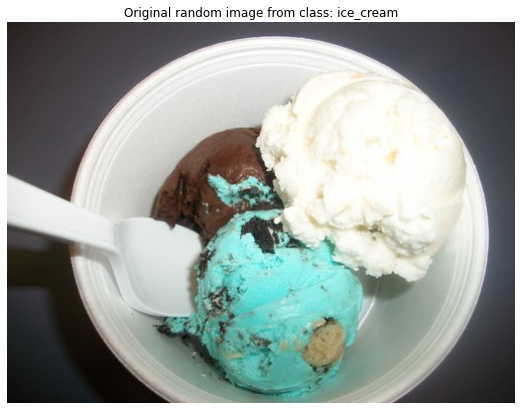

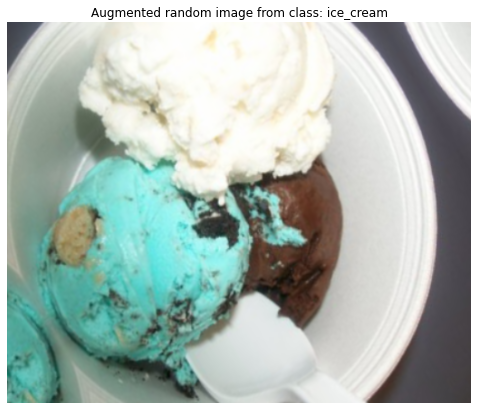

In [31]:
# view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# read in the random image
img = mpimg.imread(random_image_path)

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
plt.show()

# augment the image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0), training=True)
plt.figure(figsize=(10,7))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.show()

Because we're going to add the data augmentation model as a layer in our upcoming transfer learning mdoel, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you ware taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

## Model 1: Feature extraction transfer learning on 1% of the data augmentation

In [32]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layer
inputs = layers.Input(shape=input_shape,
                      name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs after augmentation and don't train it
x = base_model(x, training=False)

# Pool ouput features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(len(train_data_1_percent.class_names), activation="softmax", name="ouput_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

In [33]:
# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to :transfer_learning/1_percent_data_aug/2022-10-10_17:40:05
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4028 - accuracy: 0.1000 - val_loss: 2.2295 - val_accuracy: 0.1826
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1372 - accuracy: 0.3143 - val_loss: 2.1260 - val_accuracy: 0.2385
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9229 - accuracy: 0.4143 - val_loss: 2.0213 - val_accuracy: 0.2862
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7976 - accuracy: 0.5429 - val_loss: 1.9140 - val_accuracy: 0.3520
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6304 - accuracy: 0.6286 - val_loss: 1.8218 - val_accuracy: 0.4276


Using only 7 training images per class, using transfer learning our model was able to get ~45% accuracy on the validation set. This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with all the data, namely, 750 training images per class.

In [35]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

We've now got data augmentation built right into our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [36]:
# Evaluate on the test data
model_1.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 1.8282 - accuracy: 0.4308


[1.8281517028808594, 0.4307999908924103]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line `validation_steps=int(0.25 * len(test_data))`. Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

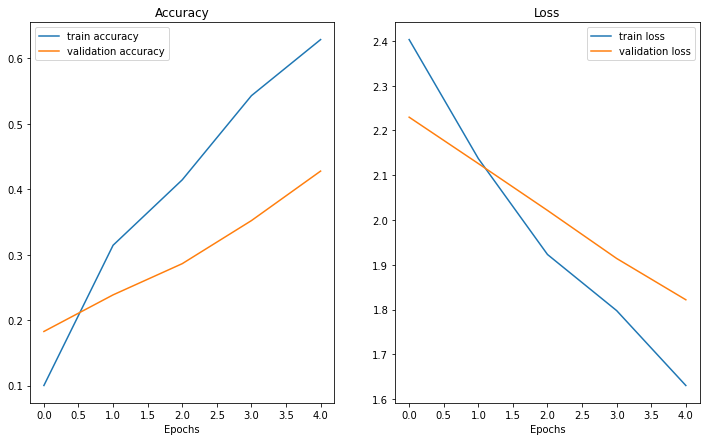

In [37]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_model_1)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now, we've got more experiments to do!

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

We've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

> **Question**: How do you know what experiments to run?

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow yout curiosity as tenaciously as possible. if you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [38]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

In [39]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [40]:
# How many images in our directory?
walk_through_dir(train_dir_10_percent)

10_food_classes_10_percent/train/: There are 10 directories and 0 files
10_food_classes_10_percent/train/pizza: There are 0 directories and 75 files
10_food_classes_10_percent/train/ice_cream: There are 0 directories and 75 files
10_food_classes_10_percent/train/chicken_wings: There are 0 directories and 75 files
10_food_classes_10_percent/train/chicken_curry: There are 0 directories and 75 files
10_food_classes_10_percent/train/sushi: There are 0 directories and 75 files
10_food_classes_10_percent/train/hamburger: There are 0 directories and 75 files
10_food_classes_10_percent/train/fried_rice: There are 0 directories and 75 files
10_food_classes_10_percent/train/ramen: There are 0 directories and 75 files
10_food_classes_10_percent/train/grilled_salmon: There are 0 directories and 75 files
10_food_classes_10_percent/train/steak: There are 0 directories and 75 files


In [41]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Understand the transfer learning and fine-tuning with keras : [Transfer Learning & fine-tuning Guide](https://keras.io/guides/transfer_learning/)

**Layers and models also feature a boolean attribute `trainable`**. Its value can be changed. Setting `layer.trainable = False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training.

**[Build a model](https://keras.io/guides/transfer_learning/#build-a-model)**:
- We make sur to pass `training=False` when calling the base model, so that it runs in inference mdoe, so that batchnorm statistic don't get updated even after we unfreeze the base model for fine-tuning

In [42]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255.) # keep for ResNet50V2, remove for EfficientNet    
], name="data_augmentation")

# setup the input shape to our model
input_shape = IMG_SIZE + (3,)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images

# The base model contains batchnorm layer. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the 
# base_model is running in inference mode here
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [43]:
# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
# summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The `ModelCHeckpoint` callback gives you the ability to save your model, as a whole in the `SavedModel` format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being training for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning mdoel for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specify a directory we'd like to save to.

In [45]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

The `SavedModel` format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

### Fit Model 2

In [46]:
# fit the model
initial_epochs = 5

history_model2 = model_2.fit(train_data_10_percent,
                             epochs=initial_epochs,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug"),
                                        checkpoint_callback])

Saving TensorBoard log files to :transfer_learning/10_percent_data_aug/2022-10-10_17:40:55
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0121 - accuracy: 0.3347
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 518ms/step - loss: 2.0121 - accuracy: 0.3347 - val_loss: 1.5047 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3682 - accuracy: 0.6920
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 438ms/step - loss: 1.3682 - accuracy: 0.6920 - val_loss: 1.0685 - val_accuracy: 0.7451
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0626 - accuracy: 0.7373
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 372ms/step - loss: 1.0626 - accuracy: 0.7373 - val_loss: 0.8839 - val_accuracy: 0.782

In [47]:
# evaluate our model2
results_evaluate_model2 = model_2.evaluate(test_data)
results_evaluate_model2

79/79 [==============================] - 6s 72ms/step - loss: 0.6949 - accuracy: 0.8100


[0.6949021220207214, 0.8100000023841858]

In [48]:
# evaluate our model0
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6086 - accuracy: 0.8388


[0.6086381673812866, 0.8388000130653381]

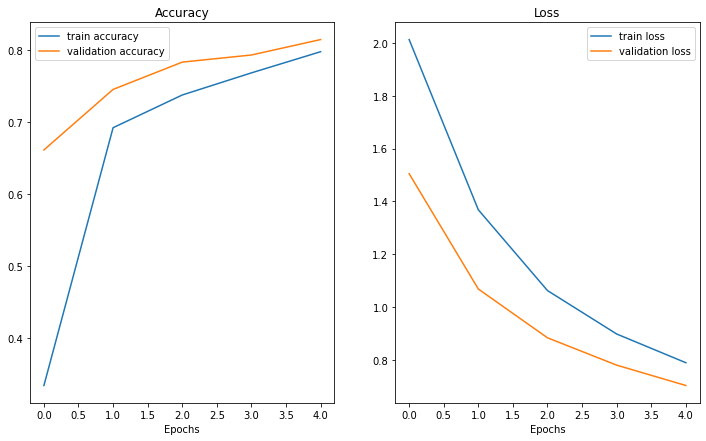

In [49]:
# plot loss curves
plot_loss_curves(history_model2)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above). However the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluating it on the test data.

To load saved model weights you can use the `load_weights()` method, passing it the path where your saved weights are stored.

### Saved weights 

In [50]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [51]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 86ms/step - loss: 0.6949 - accuracy: 0.8100


Now let's compare the results of our previously trained model and the loaded model. These results should be very close if not exactly the same. The reason for minor differences comes down to the precision level of numbers calculated.

In [52]:
loaded_weights_model_results == results_evaluate_model2

False

If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

However, they should be very close...

In [53]:
results_evaluate_model2, loaded_weights_model_results

([0.6949021220207214, 0.8100000023841858],
 [0.6949021816253662, 0.8100000023841858])

In [54]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_evaluate_model2), np.array(loaded_weights_model_results))

array([ True,  True])

In [55]:
# Check the difference between the two results
print(np.array(results_evaluate_model2)-np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll ne unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data.

### Preparing Model 3

In [56]:
# Layers in loaded model
model_2.layers

In [57]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd10a6dbc50> True
<keras.engine.sequential.Sequential object at 0x7fd10a6db890> True
<keras.engine.functional.Functional object at 0x7fd10a241d50> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd10a6dbd50> True
<keras.layers.core.dense.Dense object at 0x7fd10b0ea8d0> True


In [58]:
# Check the summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [59]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [60]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally we should see the mmodel's performance improve.

> **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every later in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

To begin fine-tuning, we'll unfreeze the entire base model by settings its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to `False`. Finally we'll recompile the model

In [61]:
base_model.trainable = True

# Freeze all layers except for the last 10 
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (we have to recompile our models every time we make a change)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

> **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x.

In [62]:
# Check which layers are trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

> **Question:** Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

In [63]:
print(len(model_2.trainable_variables))

12


It looks like our model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we use the `initial_epoch` parameter of the `fit()` method. We'll pass it the last epoch of the previous model's training history(`history_10_percent_data_aug.epoch[-1]`).

### Fitting and evaluating Model 3

In [64]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_model2_fine = model_2.fit(train_data_10_percent,
                                  epochs=fine_tune_epochs,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25 * len(test_data)),
                                  initial_epoch=history_model2.epoch[-1], # start from previous last epoch
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to :transfer_learning/10_percent_fine_tune_last_10/2022-10-10_17:42:28
Epoch 5/10
24/24 [==============================] - 18s 434ms/step - loss: 0.7062 - accuracy: 0.8147 - val_loss: 0.5657 - val_accuracy: 0.8158
Epoch 6/10
24/24 [==============================] - 9s 380ms/step - loss: 0.5654 - accuracy: 0.8360 - val_loss: 0.4839 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 10s 397ms/step - loss: 0.4991 - accuracy: 0.8547 - val_loss: 0.4751 - val_accuracy: 0.8421
Epoch 8/10
24/24 [==============================] - 8s 301ms/step - loss: 0.4553 - accuracy: 0.8627 - val_loss: 0.5104 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 8s 336ms/step - loss: 0.4260 - accuracy: 0.8733 - val_loss: 0.4510 - val_accuracy: 0.8503
Epoch 10/10
24/24 [==============================] - 9s 359ms/step - loss: 0.3757 - accuracy: 0.8880 - val_loss: 0.4631 - val_accuracy: 0.8339


In [65]:
# Evaluate the model on test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4921 - accuracy: 0.8284


Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

### Comparing our model's results before and after fine-tuning

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

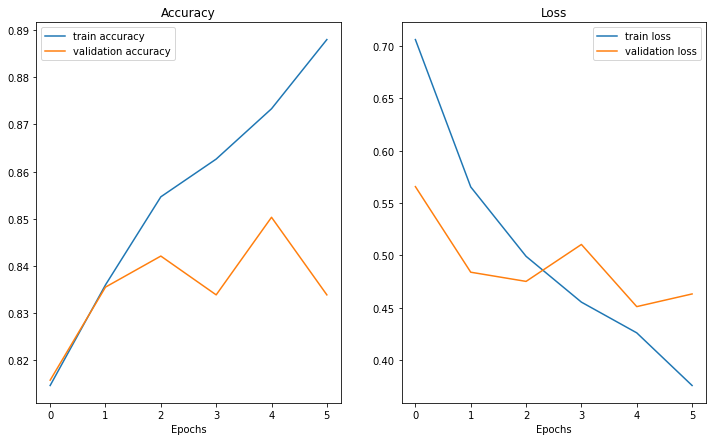

In [66]:
plot_loss_curves(history_model2_fine)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [67]:
# Let's create a function to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.

  Arguments:
  - original history (history_object): history of a model before fine tuning
  - new_history (history_object):history of a model after fine tuning
  - initial_epochs (int): number of initial epochs
  """

  # Get the original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(10,7))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Training Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(10,7))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Training Val loss")
  plt.axvline(initial_epochs-1,color = 'g', linestyle="--", label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation loss")

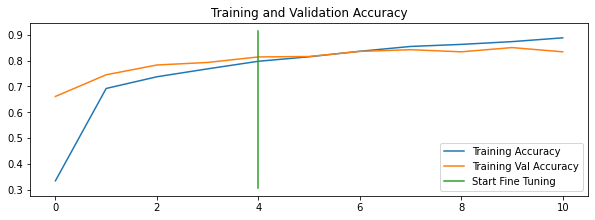

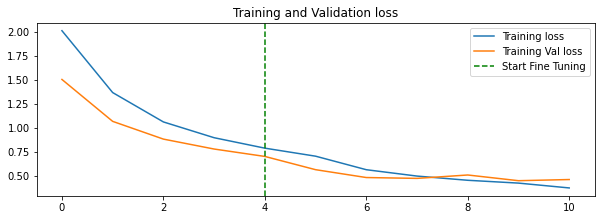

In [68]:
compare_historys(history_model2, history_model2_fine, initial_epochs=5)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## Model 4: Fine-tuning an existing model all of the data

Fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.

### Download and prepare data 

In [69]:
# Download  
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

--2022-10-10 17:49:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  74.1MB/s    in 7.5s    

2022-10-10 17:49:29 (66.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [70]:
# unzip 10 classes of Food101 data with all images 

unzip_data("10_food_classes_all_data.zip")

In [71]:
# How many images are in our dataset?
walk_through_dir("10_food_classes_all_data")

10_food_classes_all_data: There are 2 directories and 0 files
10_food_classes_all_data/train: There are 10 directories and 0 files
10_food_classes_all_data/train/pizza: There are 0 directories and 750 files
10_food_classes_all_data/train/ice_cream: There are 0 directories and 750 files
10_food_classes_all_data/train/chicken_wings: There are 0 directories and 750 files
10_food_classes_all_data/train/chicken_curry: There are 0 directories and 750 files
10_food_classes_all_data/train/sushi: There are 0 directories and 750 files
10_food_classes_all_data/train/hamburger: There are 0 directories and 750 files
10_food_classes_all_data/train/fried_rice: There are 0 directories and 750 files
10_food_classes_all_data/train/ramen: There are 0 directories and 750 files
10_food_classes_all_data/train/grilled_salmon: There are 0 directories and 750 files
10_food_classes_all_data/train/steak: There are 0 directories and 750 files
10_food_classes_all_data/test: There are 10 directories and 0 files
10_

In [72]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir_all_data = "10_food_classes_all_data/test/"

In [73]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We've got 10x more images in of the training classes to work with.

The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

### Preparing our final model

In [74]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.4921 - accuracy: 0.8284


[0.4921403229236603, 0.8284000158309937]

In [75]:
results_fine_tune_10_percent

[0.49214038252830505, 0.8284000158309937]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [76]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [77]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6949 - accuracy: 0.8100


[0.6949020624160767, 0.8100000023841858]

In [78]:
# Check to see if the above two results are the same (they should be)
results_evaluate_model2

[0.6949021220207214, 0.8100000023841858]

We've done the following steps:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yes, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [81]:
# Check which layers are tunable in the whole model
for i, layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [82]:
# Let's drill into our base model and see what layers are trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!